In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path
from scipy.optimize import curve_fit

import sys
sys.path.append("../src")

from data_prep import *
from make_cuts import *
from fitting_functions import *
from pulse_profile_generator import *
from plot_maker import *
from energy_resolution import *

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
runs=[300,301,302,303,304,305,307]

c_folder="../../data/calibration/"
d_folder="../../data/runData/"

In [4]:
%%time
p0_s=[]
p1_s=[]
for r_n in runs:
    # make folder for plots
    Path("../../plots").mkdir(parents=True, exist_ok=True)
    Path("../../plots/run_"+str(r_n)).mkdir(parents=True, exist_ok=True)
    p_folder="../../plots/run_"+str(r_n)+"/"

    p,m,r=import_data(c_folder,d_folder, r_n, is_it_pulsed=False)
    r=select_bars_with_data(r,p, subtract_pedestal=True, is_it_pulsed=False)
    r=first_layer_cut(r)
    r=back_layer_cut(r,5)

    p0,p1=make_gaussian_fit_plot(r,m,r_n,p_folder, save_plot=True)

    p0_s.append(p0[:-1])
    p1_s.append(p1[:-1])

Number of events: 71416


Initial pedestal-based selection performed.
Events left: 71415


Events with multiple hits in first layer removed.
Events left: 42333


Events with hits in the back 5 layers removed.
Events left: 31066


Number of events: 92038


Initial pedestal-based selection performed.
Events left: 91978


Events with multiple hits in first layer removed.
Events left: 63987


Events with hits in the back 5 layers removed.
Events left: 61267


Number of events: 100534


Initial pedestal-based selection performed.
Events left: 99704


Events with multiple hits in first layer removed.
Events left: 75163


Events with hits in the back 5 layers removed.
Events left: 73234


Number of events: 105912


Initial pedestal-based selection performed.
Events left: 104450


Events with multiple hits in first layer removed.
Events left: 80916


Events with hits in the back 5 layers removed.
Events left: 79071


Number of events: 67621


Initial pedestal-based selection performed.
Events 

In [5]:
res_df, low_df=make_result_df(p0_s, p1_s, runs, c_folder, True)

In [6]:
linear_plot(res_df, 0, True, low_df, True)
linear_plot(res_df, 1, True, low_df, True)

In [8]:
def hyper_fit(redult_df, end, exclude_high_energy=False, low_result_df=None):
    mu="mu_end"+str(int(end))
    sigma="sigma_end"+str(int(end))

    truth=result_df[sigma]/result_df[mu]
    param, pcov=curve_fit(hyperbolic, result_df["beam_energy"], truth)
    perr=np.sqrt(np.diag(pcov))

    if exclude_high_energy==True:
        truth_low=low_result_df[sigma]/low_result_df[mu]
        param_low, pcov_low=curve_fit(hyperbolic, low_result_df["beam_energy"], truth_low)
        perr_low=np.sqrt(np.diag(pcov_low))
        return param, perr, param_low, perr_low

    return param, perr

In [9]:
# def hyperbolic_plot(result_df, end, exclude_high_energy=False, low_result_df=None, save_plot=False):
    

In [14]:
truth=res_df["sigma_end0"]/res_df["mu_end0"]
truth_low=low_df["sigma_end0"]/low_df["mu_end0"]

param, pcov=curve_fit(hyperbolic, res_df["beam_energy"], truth)
param_low, pcov_low=curve_fit(hyperbolic, low_df["beam_energy"], truth_low)

perr=np.sqrt(np.diag(pcov))
perr_low=np.sqrt(np.diag(pcov_low))

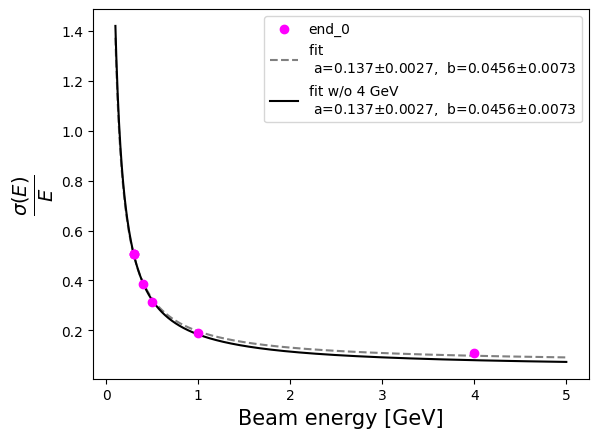

In [16]:
plt.scatter(res_df["beam_energy"], res_df["sigma_end0"]/res_df["mu_end0"], color="magenta",zorder=4, label="end_0")
sample=np.linspace(0.1, 5, 1000)

plt.plot(sample, hyperbolic(sample, *param), linestyle="--", color="gray",zorder=2,
         label=r"fit ""\n"" a="+str(round(param_low[0],3))+"$\pm$"+str(round(perr_low[0],4))+
         ",  b="+str(round(param_low[1],4))+"$\pm$"+str(round(perr_low[1],4)))

plt.plot(sample, hyperbolic(sample, *param_low), linestyle="-", color="black",zorder=3,
         label=r"fit w/o 4 GeV ""\n"" a="+str(round(param_low[0],3))+"$\pm$"+str(round(perr_low[0],4))+
         ",  b="+str(round(param_low[1],4))+"$\pm$"+str(round(perr_low[1],4)))
plt.xlabel("Beam energy [GeV]", fontsize=15)
plt.ylabel(r"$\frac{\sigma (E)}{E}$", fontsize=20)
plt.legend()
plt.savefig("../../plots/hcal_resolution_electron_end_"+str(0)+".png", bbox_inches='tight')
plt.show()

Number of events: 47351


Initial pedestal-based selection performed.
Events left: 46271


Events with multiple hits in first layer removed.
Events left: 37232


Events with hits in the back 5 layers removed.
Events left: 36506




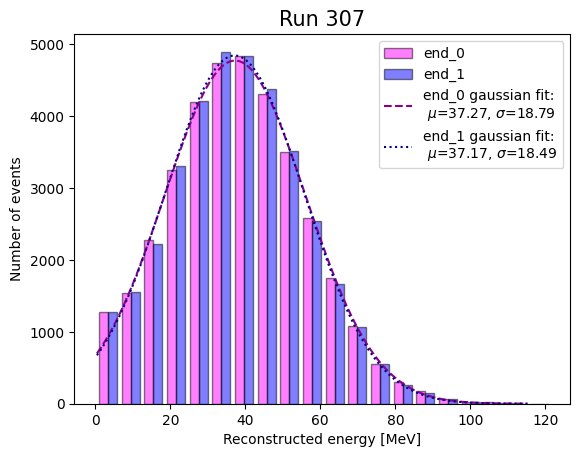

CPU times: user 9.32 s, sys: 1.93 s, total: 11.3 s
Wall time: 11.3 s


In [4]:
%%time
r_n=307

Path("../../plots").mkdir(parents=True, exist_ok=True)
Path("../../plots/run_"+str(r_n)).mkdir(parents=True, exist_ok=True)
p_folder="../../plots/run_"+str(r_n)+"/"

p,m,r=import_data(c_folder,d_folder, 305, is_it_pulsed=False)
r=select_bars_with_data(r,p, subtract_pedestal=True, is_it_pulsed=False)
r=first_layer_cut(r)
r=back_layer_cut(r,5)
p0,p1=make_gaussian_fit_plot(r,m,r_n,p_folder, save_plot=False)